In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from functools import cached_property

# Anisotropic scattering under stationary conditions
General solution
\begin{align}
\textbf{E}&=\sum_{i=1}^2c_i\textrm{e}^{\lambda_i (x-x_i)}\textbf{v}_i
\end{align}
Boundary conditions:
\begin{align}
1&=\sum_{i=0}^1c_i\textrm{e}^{-\lambda_i x_i}\textbf{v}_{i0}\\
0&=\sum_{i=0}^1c_i\textrm{e}^{\lambda_i (w-x_i)}\textbf{v}_{i1}
\end{align}

## Class to handle general case ($\varepsilon>0$)

In [2]:
class StationaryAniso:
    """ Solve the general problem (non-zero dissipation) """
    def __init__(self, eps=0., beta=0, w=.1):
        """
        Parameters:
        -----------
        w : float
            MIZ width (>0)
        beta : float
            Directional dependence parameter (-1<=beta<=1)
        eps : float
            Dissipation (>=0)
            
        Sets:
        --------
        self.w
            MIZ width (>0)
        self.beta
            Directional dependence parameter (-1<=beta<=1)
        self.eps
            Dissipation (>=0)
        self.evals : numpy.ndarray
            Eigenvalues
        self.evecs : numpy.ndarray
            Eigenvectors in columns
        """
        self.eps = eps
        self.beta = beta
        self.w = w
        self.evals, self.evecs = np.linalg.eig(self.matrix)

    @cached_property
    def matrix(self):
        """
        Returns:
        --------
        matrix : numpy.ndarray
            Matrix A in equation E_x = A E
        """
        a = -self.eps - .5*(1 + self.beta)
        b = - .5*(1 - self.beta)
        c = - .5*(1 + self.beta)
        d = self.eps - .5*(1 - self.beta)
        return np.array([[a,b], [c,d]])

    @cached_property
    def eig_tuples(self):
        """
        Returns:
        --------
        eig_tuples : list
            Each iteration is a tuple (lam, vec, xe):
                lam : float
                    Eigenvalue
                vec : numpy.ndarray
                    Eigenvector
                xe : float
                    Source of waves (should decay away from source for 0<=x<=w).
                    If lam<=0, xe=0; if lam>0, xe=w.
        """
        tups = []
        for i in range(2):
            lam = self.evals[i]
            vec = self.evecs[:,i]
            xe = 0. if lam <= 0. else self.w
            tups += [(lam, vec, xe)]
        return tups

    @cached_property
    def coeffs(self):
        """
        Returns:
        --------
        coeffs: numpy.ndarray
            Coefficients of eigenfunction expansion. Shape is (2,)
        """
        b = np.array([1.,0.])
        a = np.zeros((2,2))
        x = np.array([0., self.w])
        for i, (lam, vec, xe) in enumerate(self.eig_tuples):
            a[:,i] = vec * np.exp(lam * (x - xe))
        return np.linalg.solve(a, b)

    def calc_expansion(self, x):
        """
        Parameters:
        -----------
        x : numpy.ndarray
            x values where energy should be calculated.
            Shape is (nx,)
        
        Returns:
        --------
        E : numpy.ndarray
            Energy calculated at x.
            Shape is (2,nx)
            - 1st row is E_+ (energy going to the right)
            - 2nd row is E_- (energy going to the left)
        """
        u = 0.
        for (lam, vec, xe), coeff in zip(self.eig_tuples, self.coeffs):
            u += coeff * np.outer(vec, np.exp(lam * (x - xe)))
        return u
    
    def calc_wave_stress(self, x):
        """
        Parameters:
        -----------
        x : numpy.ndarray
            x values where energy should be calculated.
            Shape is (nx,)
        
        Returns:
        --------
        tau_x : numpy.ndarray
            Wave stress on ice.
            Shape is (nx,)
        """
        ep, em = self.calc_expansion(x)
        etot = ep + em
        edel = ep - em
        return 2 * (etot + self.beta * edel) + self.eps * edel

## Class to handle special case when $\varepsilon=0$

In [3]:
class StationaryAnisoNoDissipation(StationaryAniso):
    """ 
    Solve the zero dissipation problem analytically.
    Mainly to check the general solution method.
    """

    def __init__(self, w=.1, beta=0):
        """
        Parameters:
        -----------
        w : float
            MIZ width (>0)
        beta : float
            directional dependence parameter (-1<=beta<=1)
        """
        self.w = w
        self.beta = beta
        self.eps = 0. #no dissipation

    @cached_property
    def alpha(self):
        """
        Returns:
        --------
        alpha : float
            convenience variable (1 - beta)/(1 + beta)
        """
        b = self.beta
        return (1 - b)/(1 + b)

    @cached_property
    def coeffs(self):
        """
        Returns:
        --------
        coeffs: numpy.ndarray
            coefficients of eigenfunction expansion. Shape is (2,)
        """
        a = self.alpha
        ex = np.exp(-self.w)
        c2 = ex/(1 + a * ex)
        c1 = 1 - c2 * a
        return np.array([c1, c2])

    def calc_expansion(self, x):
        """
        Parameters:
        -----------
        x : numpy.ndarray
            x values where energy should be calculated.
            Shape is (nx,)
        
        Returns:
        --------
        E : numpy.ndarray
            energy calculated at x.
            Shape is (2,nx)
            - 1st row is E_+ (energy going to the right)
            - 2nd row is E_- (energy going to the left)
        """
        c1, c2 = self.coeffs
        a = self.alpha
        cex = c1 * np.exp(-x)
        ep = cex + c2 * a
        em = cex - c2
        return np.array([ep, em])

## Solve and test the boundary conditions

In [4]:
sa = StationaryAniso()
x = np.array([0., sa.w])
ep, em = sa.calc_expansion(x)
print(f'E_+(0)=1? {ep[0]}')
print(f'E_-(w)=0? {em[1]}')

E_+(0)=1? 1.0
E_-(w)=0? -5.551115123125783e-17


In [5]:
sa0 = StationaryAnisoNoDissipation()
ep, em = sa.calc_expansion(x)
print(f'E_+(0)=1? {ep[0]}')
print(f'E_-(w)=0? {em[1]}')

E_+(0)=1? 1.0
E_-(w)=0? -5.551115123125783e-17


In [6]:
sa0.calc_wave_stress(x)

array([2.09991675, 1.90008325])

In [7]:
sa.calc_wave_stress(x)

array([2.09991675, 1.90008325])

In [8]:
# check boundary conditions with dissipation
sa = StationaryAniso(eps=2)
x = np.array([0., sa.w])
ep, em = sa.calc_expansion(x)
print(f'E_+(0)=1? {ep[0]}')
print(f'E_-(w)=0? {em[1]}')

E_+(0)=1? 1.0
E_-(w)=0? 1.3877787807814457e-17


## Plots to see effect of $\beta$ without dissipation
Also look at convergence to the wide-MIZ asymptote

In [9]:
def plot_energy(cls, x, plot_var='E', ax=None, legend_text=None, log_scale=False, **kwargs):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    sa = cls(**kwargs)
    ep, em = sa.calc_expansion(x)
    if plot_var == "E":
        y = ep + em
    else:
        assert(plot_var == "\delta")
        y = ep - em
    ax.plot(x, y, label=legend_text)
    ax.set_xlabel('$x$')
    ax.set_ylabel(f'${plot_var}$')
    if log_scale:
        ax.set_yscale('log')
    return ax

In [28]:
def plot_one_panel(w, log_scale, eps=0., plot_var='E', title=None,
                   add_asymptote=True, ax=None, add_legend=True):
    x = np.linspace(0, w, 50)
    for b in [-.8, -.4, 0, .4, .8]:
        ax = plot_energy(StationaryAniso, x,
                         ax=ax, beta=b, w=w,
                         eps=eps, plot_var=plot_var,
                         legend_text=f"{b}",
                         log_scale=log_scale,
                        )
    if title is None:
        title = f'${w=}$'
    ax.set_title(title)
    if add_asymptote:
        ax.plot(x, 2 * np.exp(-x), ':k', label='$w=\infty$')
    if add_legend:
        ax.legend()
    return ax

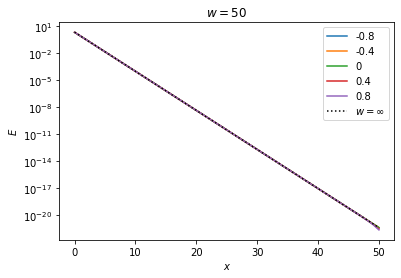

In [29]:
w, log_scale, add_asym = 50, True, True
# w, log_scale, add_asym = 10, True, True
# w, log_scale, add_asym = 7, True, True
# w, log_scale, add_asym = 5, True, True
# w, log_scale, add_asym = 3, False, True
ax = plot_one_panel(w, log_scale, add_asymptote=add_asym)

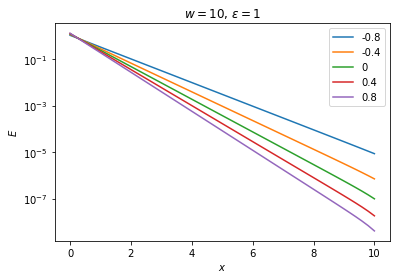

In [34]:
# w, eps, log_scale, add_asym = 3, 1, False, False
w, eps, log_scale, add_asym = 10, 1, True, False
title = fr'${w=}$, $\varepsilon={eps}$'
ax = plot_one_panel(w, log_scale, add_asymptote=add_asym,
                    eps=1, plot_var='E', title=title)

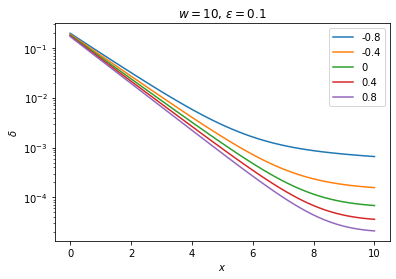

In [35]:
# w, eps, log_scale, add_asym = 3, .1, False, False
w, eps, log_scale, add_asym = 10, .1, True, False
title = fr'${w=}$, $\varepsilon={eps}$'
ax = plot_one_panel(w, log_scale, add_asymptote=add_asym,
                    eps=0.1, plot_var='\delta', title=title)

In [14]:
def get_energy_fig(eps=0, add_asyms=True):
    fig, axs = plt.subplots(1, 4)
    ws = [1, 2, 5, 10] # width
    lss = [False, False, True, True] #log scale
    if add_asyms:
        aas = [False, True, True, True] # add wide MIZ asymptote
    else:
        aas = 4 * [False]
    for i, (ax, w, log_scale, add_asym) in enumerate(
        zip(axs, ws, lss, aas)):
        ax = plot_one_panel(w, log_scale, ax=ax,
                            eps=eps, plot_var='E',
                            add_asymptote=add_asym,
                            add_legend=(i == len(ws) - 1),
                           )
    return fig

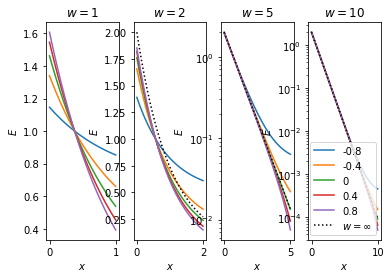

In [15]:
fig = get_energy_fig()
os.makedirs('paper_figs', exist_ok=True)
fig.savefig('paper_figs/energy_w_beta.png')

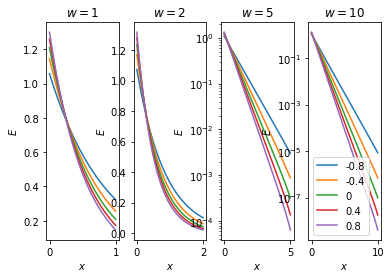

In [16]:
fig = get_energy_fig(eps=1, add_asyms=False)
# fig.savefig('paper_figs/energy_w_beta.png')

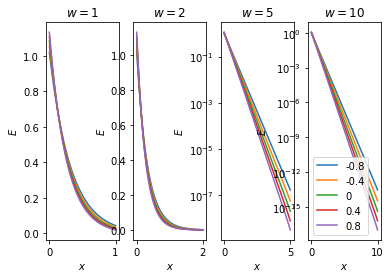

In [17]:
fig = get_energy_fig(eps=3, add_asyms=False)
# os.makedirs('paper_figs', exist_ok=True)
# fig.savefig('paper_figs/energy_w_beta.png')

In [36]:
def get_fig_E_and_delta(w=1, eps=0, log_scale=True):
    """ side by side plots of E and \delta """
    fig, axs = plt.subplots(1, 2)
    for i, (ax, plot_var) in enumerate(
        zip(axs, ['E', '\delta'])):
        title = fr'${w=}$, $\varepsilon={eps}$'
        ax = plot_one_panel(w, log_scale, ax=ax,
                            eps=eps, plot_var=plot_var,
                            title=title,
                            add_asymptote=False,
                            add_legend=(i == 1),
                           )
    return fig

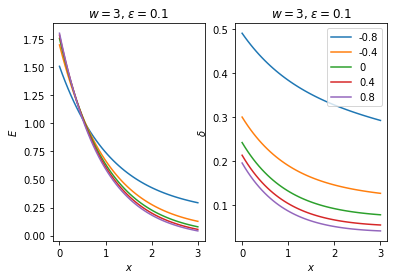

In [37]:
w, eps, log_scale = 3, .1, False
# w, eps, log_scale = 10, .1, True
# w, eps, log_scale = 3, 1, True
_ = get_fig_E_and_delta(w=w, eps=eps, log_scale=log_scale)

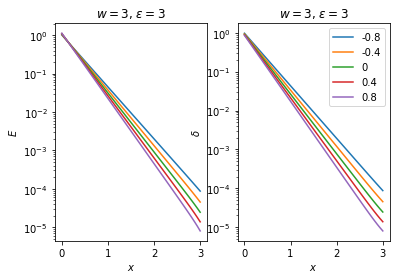

In [38]:
# w, eps, log_scale = 3, .1, False
# w, eps, log_scale = 10, .1, True
w, eps, log_scale = 3, 3, True
_ = get_fig_E_and_delta(w=w, eps=eps, log_scale=log_scale)

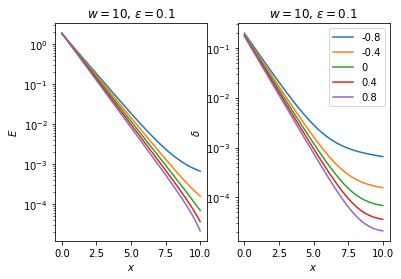

In [39]:
# w, eps, log_scale = 3, .1, False
w, eps, log_scale = 10, .1, True
# w, eps, log_scale = 3, 3, True
_ = get_fig_E_and_delta(w=w, eps=eps, log_scale=log_scale)

In [40]:
def plot_flux(eps=0, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    beta = np.linspace(-1, 1, 50)
    w_all = [1,2,3]
    x = np.zeros((1,))
    for w in w_all:
        fluxes = []
        for b in beta:
            sa = StationaryAniso(beta=b, w=w, eps=eps)
            ep, em = sa.calc_expansion(x)
            fluxes +=  [ep - em]
        ax.plot(beta, fluxes, label=f'${w=}$')
    ax.set_xlabel(r'$\beta_{aniso}$')
    ax.set_ylabel(r'$\delta(0)$')
    ax.set_title(fr'$\varepsilon={eps}$')
    ax.legend()
    return ax

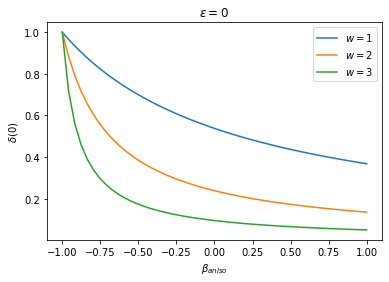

In [41]:
_ = plot_flux()

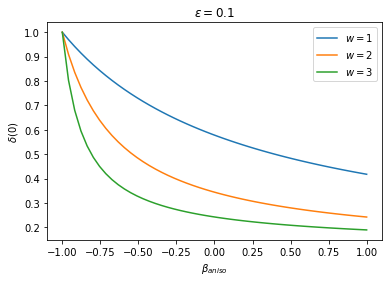

In [42]:
_ = plot_flux(eps=.1)

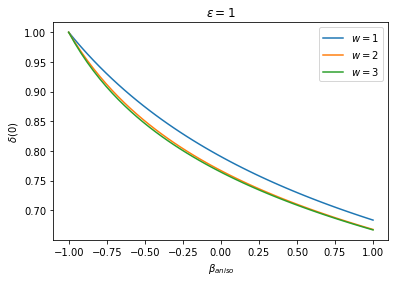

In [43]:
_ = plot_flux(eps=1)

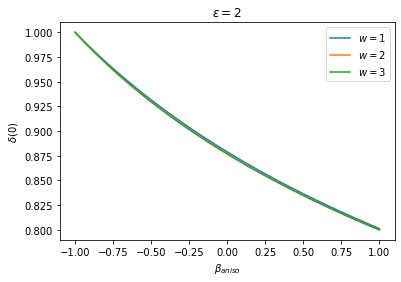

In [44]:
_ = plot_flux(eps=2)